# Mask-Detection using Transfer Learning


we will use transfer learning to detect if the person is wearing a mask or not. We will use a pre-trained model (MobileNet-V1) trained on the ImageNet dataset and use a modified version of [kaggle mask dataset](https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset) to preform transfer learning.
we will customize a pretrained model as follows :
1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples.
2. we will follow the general machine learning workflow.

   1. Examine and understand the data
   1. Build an input pipeline, in this case using Keras ImageDataGenerator
   1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
   1. Train the model
   1. Evaluate model

**Import libraries:**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

**Build The Dataset:**

**Download The dataset:**

we will use a dataset containing several hundreds images of person with and without mask.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1lYOgCLLJU8TCIeTxJHkjsxBq_GPzQYb9

In [ ]:
!unzip edx_transfer_learningv3.zip

In [5]:
import os
os.chdir("/content/edx_transfer_learningv3/edx_transfer_learning/train/without_mask")

In [6]:
path_to_zip = "/content/"
PATH = os.path.join(os.path.dirname(path_to_zip), 'edx_transfer_learningv3/edx_transfer_learning/')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (96, 96)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 602 files belonging to 2 classes.


In [7]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Now that we have built the dataset lets view the first nine images and labels from the training set

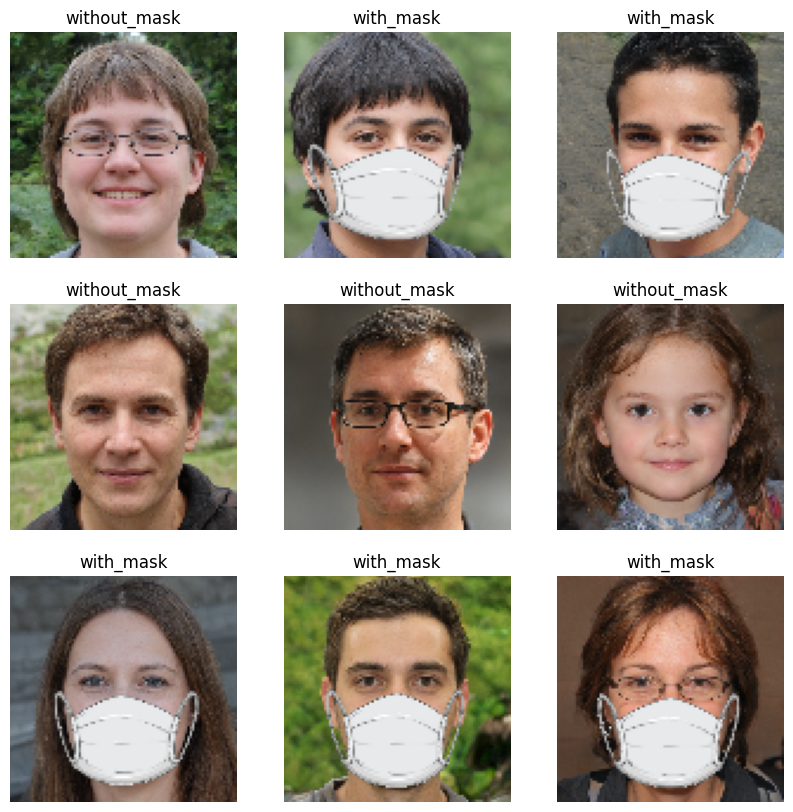

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Split The Dataset:**

as the original dataset doesn't contain a test set , we need to create one To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


**Configure the dataset for performance:**
Use buffered prefetching to load images from disk without having I/O become blocking.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Use data augmentation:**
if you don't have a large image dataset,you could apply random, yet realistic, transformations to the training images to expand the dataset.For example: apply rotations or flip the data horizontally.

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

apply these layers to the same image and see the result to better understand why this augmentation can help the dataset generalize its learning.

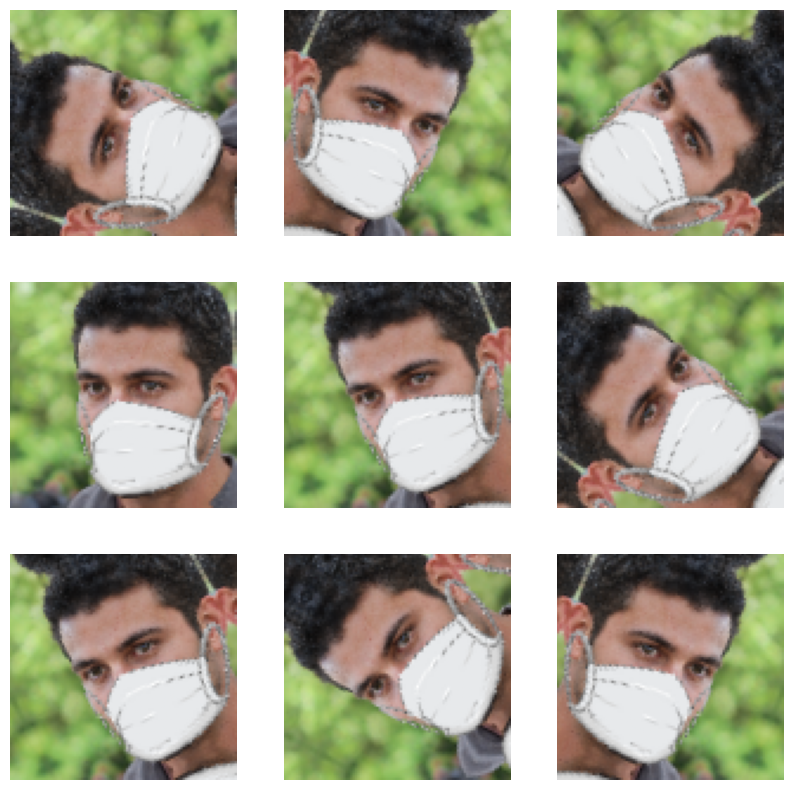

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

**Rescale pixel values:**

In [14]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset= -1)

**Build the Model:**

Create the base model:

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

<ipython-input-16-bfa777852ba1>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1024)


**Freeze the convolutional layers:**
Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.

In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 48, 48, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 48, 48, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 24, 24, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 24, 24, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 24, 24, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 24, 24, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 24, 24, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

**Add a classification head**

 we use a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the 5x5 spatial features into a single 1024-element feature vector per image.

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


We can then build our final model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). Importantly we remind Tensorflow that we do not want to train the base_model!

In [22]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compile the model**

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 3, 3, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

**Train the model**

First print the initial accuracy

In [25]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5424 - loss: 0.6560
initial loss: 0.62
initial accuracy: 0.55


**Train and Evaluate the model**

Now that we have our model we can train it! we can improve our model from a random initialization (accuracy of ~50%) to a model with over 95% accuracy quite quickly.

In [26]:
EPOCHS = 8
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.6727 - loss: 0.5029 - val_accuracy: 0.6473 - val_loss: 0.4129
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7063 - loss: 0.4556 - val_accuracy: 0.7884 - val_loss: 0.2784
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8411 - loss: 0.3081 - val_accuracy: 0.8700 - val_loss: 0.2081
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8466 - loss: 0.2294 - val_accuracy: 0.9220 - val_loss: 0.1576
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9139 - loss: 0.2064 - val_accuracy: 0.9517 - val_loss: 0.1214
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9500 - loss: 0.1389 - val_accuracy: 0.9752 - val_loss: 0.0993
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9456 - loss: 0.1252 - val_accuracy: 0.9901 - val_loss: 0.0744
Epoch 8/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9659 - loss: 0.1310 - val_accuracy: 0.9950 - val_loss: 0.0646


Lets take a look at the learning curves of the training and validation accuracy/loss to analyze our results.

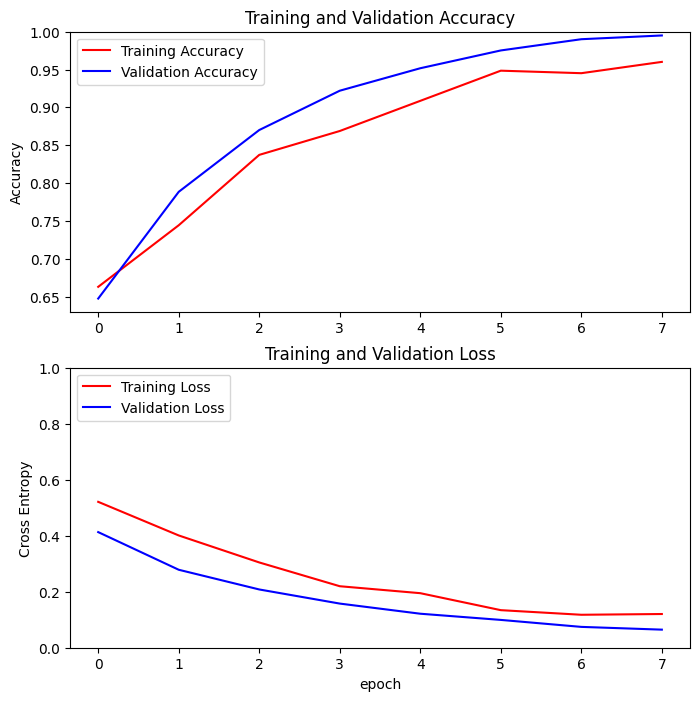

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy',c="r")
plt.plot(val_acc, label='Validation Accuracy',c="b")
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',c="r")
plt.plot(val_loss, label='Validation Loss',c="b")
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 Evaluate our model:

The last thing we need to do is check if the model is overfitting or if it actually learned the problem that fast!

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9859 - loss: 0.0699
Test accuracy : 0.9895833134651184


we are now all set to use this model to predict if the person is wearing a mask or not. Lets print the results from a bunch of the images in our test dataset!

Predictions:
 [1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0]
Labels:
 [1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0]


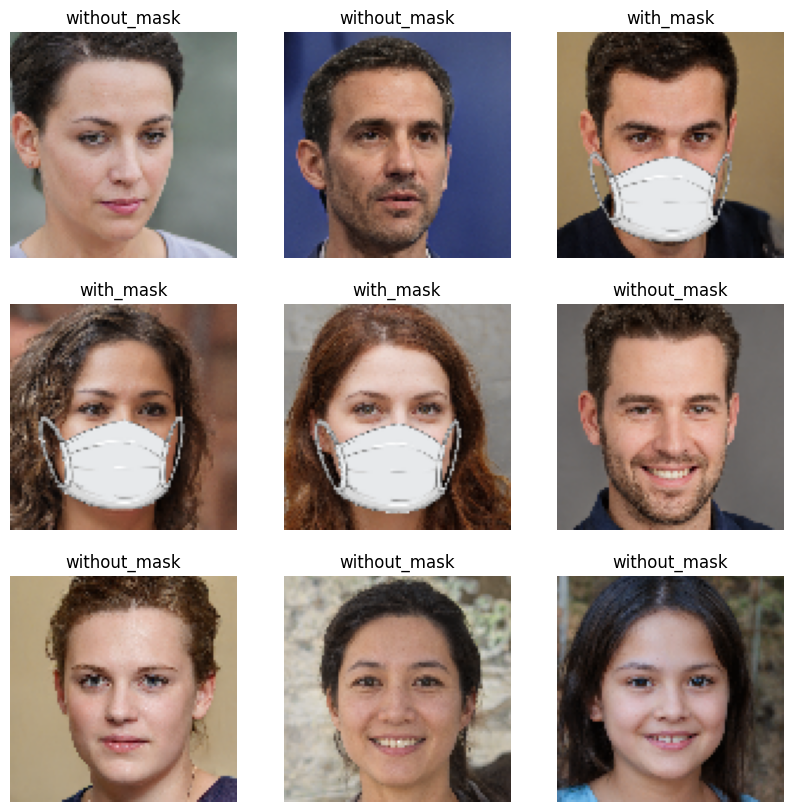

In [34]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")